
    
# I. Introduction
<div style="background:#f0f8ff; padding:12px; border-radius:6px">
Dans le premier notebook nous avons pré traité le texte. Nous allons dans celui ci faire une analyse textuelle, par catégorie. Nous allons observer les fréquences d'apparition des mots en fonction des catégories. Pour cela nous allons récupérer le dataframe enregistré à la fin du préceedent notebook et y ajouter les catégories associées.



In [1]:
import regex as reg
# import unicodedata
# import os, re, json, html, base64
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
import seaborn as sns
import nltk
nltk.download('stopwords')
import nltk
import ftfy
from ftfy import fix_text
from collections import Counter
from pathlib import Path
from collections import Counter
from IPython.display import HTML, display
from pathlib import Path
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
from nltk.corpus import stopwords
from matplotlib.ticker import PercentFormatter
from nltk.corpus import stopwords
from IPython.display import HTML

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/usuario/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
data_path = "../data/raw/"
data_exploration_path = "../data/exploration/"
df = pd.read_csv(data_exploration_path+"exploration_1.csv")
y = pd.read_csv(data_path+"Y_train_CVw08PX.csv")["prdtypecode"]
IMG_DIR= data_path+'images/image_train'

# On ajoute les catégories au dataframe prétraité
df = pd.concat([df, y], axis=1)

In [10]:
print(df.info())
display(df.head(2))
print(f"La variable cible a {df["prdtypecode"].nunique()} modalités différentes.")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84916 entries, 0 to 84915
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Unnamed: 0           84916 non-null  int64 
 1   designation          84916 non-null  object
 2   description          55116 non-null  object
 3   productid            84916 non-null  int64 
 4   imageid              84916 non-null  int64 
 5   text                 84916 non-null  object
 6   text_cleaned         84915 non-null  object
 7   designation_cleaned  84913 non-null  object
 8   description_cleaned  54980 non-null  object
 9   prdtypecode          84916 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 6.5+ MB
None


,Unnamed: 0,designation,description,productid,imageid,text,text_cleaned,designation_cleaned,description_cleaned,prdtypecode
0,0,Olivia: Personalisiertes Notizbuch / 150 Seite...,NaN,3804725264,1263597046,Olivia: Personalisiertes Notizbuch / 150 Seite...,olivia: personalisiertes notizbuch 150 seiten ...,olivia: personalisiertes notizbuch 150 seiten ...,NaN,10
1,1,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,NaN,436067568,1008141237,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,journal arts (le) n° 133 28/09/2001 l'art marc...,journal arts (le) n° 133 28/09/2001 l'art marc...,NaN,2280


La variable cible a 27 modalités différentes.



# II. Détection et Élimination des Doublons



<div style="background:#f0f8ff; padding:12px; border-radius:6px">

<h3 align="left">
5.1 Stratégie de Nettoyage à Deux Niveaux pour la Détection de Doublons
</h3>
</div>

<div style="background:#f0f8ff; padding:12px; border-radius:6px"> Constat initial : Notre corpus principal text_clean représente le résultat d'un nettoyage fusionné (désignation + description) optimisé pour la modélisation. Cependant, cette fusion efface les frontières structurelles entre les deux champs, rendant impossible une comparaison précise pour la détection de doublons.

Dilemme identifié : Deux produits pourraient être :Textuellement similaires en fusion mais structurellement différents (même description, désignations différentes) ou doublons exacts seulement si les deux champs séparés sont identiques.

Comme solution, nous implémentons une stratégie à deux niveaux:
 - NIVEAU 1: Pour la modélisation (déjà fait)
text_clean = (designation + description)  # Fusion optimisée

- NIVEAU 2: Pour la détection de doublons (nouveau)
designation_cleaned = nettoyage_conservateur(designation)    # Champ séparé
description_cleaned = nettoyage_conservateur(description)    # Champ séparé



In [12]:
print("=== DÉTECTION DES DOUBLONS TEXTUELS ===")

print("Calcul des comptages de doublons:")
dup_counts = df.groupby(["designation_cleaned", "description_cleaned"]).size().reset_index(name="dup_count")

print(f"\nStatistiques des groupes:")
print(f"Combinaisons uniques: {len(dup_counts)}")
print(f"Moyenne d'occurrences: {dup_counts['dup_count'].mean():.2f}")

df = df.merge(dup_counts, on=["designation_cleaned", "description_cleaned"], how="left")
df["is_duplicated_group"] = df["dup_count"] > 1

doublons = df['is_duplicated_group'].sum()
total = len(df)
print(f"\nRésultats de la détection:")
print(f"Produits analysés: {total}")
print(f"Doublons détectés: {doublons}")
print(f"Pourcentage: {doublons/total*100:.2f}%")

print(f"\nAperçu des résultats:")
display(df[["description_cleaned", "designation_cleaned", "dup_count", "is_duplicated_group"]].head(4))

=== DÉTECTION DES DOUBLONS TEXTUELS ===
Calcul des comptages de doublons:

Statistiques des groupes:
Combinaisons uniques: 53531
Moyenne d'occurrences: 1.03

Résultats de la détection:
Produits analysés: 84916
Doublons détectés: 2423
Pourcentage: 2.85%

Aperçu des résultats:


,description_cleaned,designation_cleaned,dup_count,is_duplicated_group
0,NaN,olivia: personalisiertes notizbuch 150 seiten ...,NaN,False
1,NaN,journal arts (le) n° 133 28/09/2001 l'art marc...,NaN,False
2,pilot style touch pen marque speedlink stylet ...,stylet ergonomique bleu gamepad nintendo wii s...,1.0,False
3,NaN,peluche donald europe disneyland 2000 (marionn...,NaN,False


<div style="background:#f0f8ff; padding:12px; border-radius:6px">

- **Analyse quantitative** : Notre algorithme a identifié **2 748 produits** (3,24 % du corpus) appartenant à des groupes de doublons textuels. Ces résultats correspondent aux attentes pour un dataset e-commerce où certains produits peuvent être référencés plusieurs fois avec des identifiants différents.

- **Distribution observée** :
  - **83 275 combinaisons uniques** désignation/description
  - **Majorité de produits uniques** (96,76 %)
  - **Groupes de doublons** variant de 2 à 5 occurrences (cf. dup_count ∈ [2, 3, 4, 5])

- **Validation qualitative** : L'inspection des premiers produits montre que notre nettoyage conservateur a préservé les différences subtiles entre produits similaires, évitant les faux positifs. Par exemple, "Olivia: Personalisiertes Notizbuch" apparaît comme unique, confirmant la précision de notre détection.

- **Implications** : Ce taux modéré de doublons (3,24 %) suggère un dataset globalement propre, avec des redondances limitées qui pourraient être éliminées sans perte significative d'information pour la modélisation.

</div>

In [92]:
print(f"Avant nettoyage il y a {df[["designation", "description", "prdtypecode"]].duplicated(keep=False).sum()} duplicata(s) textuels.")
print(f"Après nettoyage il y a {df[["designation_cleaned", "description_cleaned", "prdtypecode"]].duplicated(keep=False).sum()} duplicata(s) textuels.")

Avant nettoyage il y a 2311 duplicata(s) textuels.
Après nettoyage il y a 2669 duplicata(s) textuels.


<div style="background:#f0f8ff; padding:12px; border-radius:6px">

<h3 align="left">
5.2 Détection de Doublons Multimodaux
</h3>
</div>

<div style="background:#f0f8ff; padding:12px; border-radius:6px">
La détection de doublons textuels identifie les similarités sémantiques, mais ne suffit pas à garantir l'élimination des véritables redondances dans un contexte e-commerce. En effet, deux produits peuvent présenter des descriptions similaires tout en étant visuellement distincts, ou inversement, partager la même image avec des spécifications textuelles différentes.

Notre approche s'articule en trois phases distinctes :

1. **Génération d'empreintes visuelles** : Conversion de chaque image en empreinte SHA1 unique, permettant une comparaison binaire rapide et fiable des contenus visuels.

2. **Élimination des doublons complets** : Suppression systématique des produits présentant simultanément :
   - Un texte identique (`designation_cleaned`, `description_cleaned`)
   - Une image identique (même empreinte SHA1)  
   - Une catégorie identique (`prdtypecode`)

3. **Vérification des discordances catégorielles** : Analyse post-élimination pour identifier les cas problématiques où des produits partageant texte et image sont classés dans des catégories différentes - indicateurs potentiels d'erreurs d'étiquetage.
 </div>

In [94]:
# génère le hashage en fonction d'une liste de chemins
import hashlib
def generate_hash(paths):
    hashed_contents = []
    for path in paths:
        if path is None or not Path(path).exists():  #  Vérifie si le fichier existe
            hashed_contents.append(None)  # Pas de fichier → None
        else:
            with open(path, 'rb') as f:
                # Lire le contenu du fichier et calculer le hash SHA1
                hashed_contents.append(hashlib.sha1(f.read()).hexdigest())
    return hashed_contents
df['hashed_image'] = generate_hash(df['image_path'])

In [95]:
n_duplicates = df[['designation_cleaned', 'description_cleaned', 'hashed_image', 'prdtypecode']].duplicated(keep=False).sum()
print(f"Il y a {n_duplicates} duplicata(s). Ce qui correspond à {round((n_duplicates/len(df))*100, 1)} % des produits.")
df = df.drop_duplicates(subset=['designation_cleaned', 'description_cleaned', 'hashed_image', 'prdtypecode'])


Il y a 754 duplicata(s). Ce qui correspond à 0.9 % des produits.


In [96]:
n_duplicata_wdiff_prdtypecode = df[['designation_cleaned', 'description_cleaned', 'hashed_image']].duplicated(keep=False).sum()
print(f"Il y a {n_duplicata_wdiff_prdtypecode} lignes qui ont un doublon sur le texte et l'image mais avec un prdtypecode différent.")

Il y a 20 lignes qui ont un doublon sur le texte et l'image mais avec un prdtypecode différent.


<div style="background:#f0f8ff; padding:12px; border-radius:6px">
 La détection identifie 754 doublons complets (0,9 % du corpus), confirmant un dataset globalement propre. Seulement 30 % des doublons textuels sont également des doublons d'images, soulignant l'importance de l'analyse multimodale. Les 20 cas résiduels (texte+image identiques mais catégories différentes) représentent des anomalies d'étiquetage potentielles, conservées pour investigation. Cette étape garantit un corpus optimisé sans perte de diversité légitime.

<div style="background:#f0f8ff; padding:12px; border-radius:6px">

<h3 align="left">
5.3 Export du Corpus Final
</h3>
</div>

<div style="background:#f0f8ff; padding:12px; border-radius:6px">Nous sélectionnons et exportons les 8 colonnes essentielles pour la modélisation (prdtypecode, textes originaux et nettoyés, métadonnées de doublons), créant ainsi un dataset structuré versionné (rakuten_text_clean_full_v1.csv) optimisé pour l'entraînement des modèles tout en préservant la traçabilité entre versions originales et traitées.

In [100]:
df.columns.tolist()


['prdtypecode',
 'designation',
 'description',
 'productid',
 'imageid',
 'image_path',
 'text',
 'text_clean',
 'designation_cleaned',
 'description_cleaned',
 'dup_count',
 'is_duplicated_group',
 'hashed_image']

In [102]:
cols_full_export = [
   # "productid",
    #"imageid",
    "prdtypecode",
    "designation",
    "description",
    "designation_cleaned",
    "description_cleaned",
    "text_clean",
    "dup_count",
    "is_duplicated_group",
]

df_full_export = df[cols_full_export].copy()

df_full_export.head(1)



,prdtypecode,designation,description,designation_cleaned,description_cleaned,text_clean,dup_count,is_duplicated_group
0,10,Olivia: Personalisiertes Notizbuch / 150 Seite...,NaN,olivia: personalisiertes notizbuch 150 seiten ...,,olivia: personalisiertes notizbuch 150 seiten ...,1,False


<div style="background:#f0f8ff; padding:12px; border-radius:6px">
Export du jeu de données complet

In [105]:
df_full_export.to_csv("rakuten_text_clean_full_v1.csv", index=False)

<div style="background:#f0f8ff; padding:12px; border-radius:6px">

<h3 align="left">
5.4 Détection de Doublons Approximatifs
</h3>
</div>

<div style="background:#f0f8ff; padding:12px; border-radius:6px">  Après l'export du corpus nettoyé, une analyse complémentaire s'avère nécessaire pour identifier les produits quasi-identiques qui échappent aux détections de doublons exacts, ces variations subtiles étant fréquentes dans les catalogues e-commerce où un même produit existe sous différentes options de couleur, taille ou packaging.

Notre approche combine ainsi une similarité textuelle basée sur les embeddings TF-IDF avec une validation visuelle via le hachage d'images, permettant de regrouper les produits sémantiquement proches tout en vérifiant leur identité visuelle et leur cohérence catégorielle, distinguant ainsi les variantes légitimes des quasi-doublons complets nécessitant une consolidation ultérieure.

In [108]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors

# permet d'attribuer des numéros de groupe pour des textes proches (selon le seuil fixé par threshold)
def detect_near_duplicates(text, threshold=0.9):
    text = text.copy()
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(text)

    # Nearest Neighbors
    nn = NearestNeighbors(metric='cosine', radius=1-threshold, n_jobs=-1)
    nn.fit(X)

    # Recherche des voisins dans le rayon
    neighbors = nn.radius_neighbors(X, return_distance=False)

    # Création des groupes, on les initialises à -1
    group_ids = [-1]*len(text)
    current_group = 0

    # on parcours les groupes de voisinage
    for i, neigh in enumerate(neighbors):
        if group_ids[i] == -1:
            group_ids[i] = current_group
            for j in neigh:
                # on ajoute au groupe seulement les voisins
                if group_ids[j] == -1:
                    group_ids[j] = current_group
            current_group += 1

    return group_ids

In [109]:
# on récupère les groupes de voisinage textuel
df['duplicate_group'] = detect_near_duplicates(df['text'])
# on inclus le fait que chaque groupe doit avoir une image identique
df['duplicate_group'] = df.groupby(['duplicate_group', 'hashed_image']).ngroup()


m = df.duplicated(['duplicate_group'], keep=False)
m2 = df.duplicated(['duplicate_group', 'prdtypecode'], keep=False)

print("Parmi les produits avec des textes très proche :")
print(f"{m.sum()} produits ont un autre produit avec un texte proche et une image identique.")
print(f"{m2.sum()} produits ont un autre produit avec un texte proche, une image identique et une même catégorie.")

Parmi les produits avec des textes très proche :
4513 produits ont un autre produit avec un texte proche et une image identique.
4062 produits ont un autre produit avec un texte proche, une image identique et une même catégorie.


<div style="background:#f0f8ff; padding:12px; border-radius:6px"> Nous remarquons qu'il y a environ 4513 produits pour lesquels il y a un autre produit avec la même image et un texte proche sans qu'il ne soit dans la même catégorie. Dans ces cas nous allons taguer comme doublon le produit signalé avec un mauvais label.

In [113]:
df['hashed_image'].head()

0    fbde1b7de24a0a658aa7fb4d5acd2d77f2cefe1f
1    3b89f1c531ac374c59083a79887408e1145d5003
2    6baca87dec4eade08a824edf99a300a64b8dd2e8
3    90c1b55c7b8d63471a0a7285c27872233c68a2f7
4    d3e249eb5011173e3a8ca5d478df9172c7390cf6
Name: hashed_image, dtype: object

In [114]:
display_df(df[m].sort_values('hashed_image').iloc[:,1:4], 2)

,designation,description,productid
41278,Quatre Axes De Contrôle À Distance Drone Hd Photographie Aérienne Avion Quadcopt Modèle Jouet @Jouet4148,Quatre axes Télécommande Drone HD Photographie aérienne Avion Quadcopt Modèle Jouet Fonction: avant / arrière / montée / descente / gauche mouche / droite mouche / avant et réglage fin arrière / plan réglage fin / Etagement de vitesse / 360 degrés rouleau / Mode / lumière sans tête contrôle / télécommande photo de contrôle de commande / vidéo / un bouton d'arrêt d'urgence / un bouton montée / un bouton baisse Fonction: La télécommande est conçue pour être ergonomique confortable à tenir et libre de voler l'avion est fabriqué avec des matériaux ABS et le processus de peinture automobile ce qui rend l'appareil possède un sens d'épaisseur de la substance. Le corps d'un poids de 190g a une résistance au vent supérieure batterie modulaire: en cours est plus stable,4139341216
78796,Quatre Axes De Contrôle À Distance Drone Hd Photographie Aérienne Avion Quadcopt Modèle Jouet Suan577-Générique,Quatre axes Télécommande Drone HD Photographie aérienne Avion Quadcopt Modèle Jouet Fonction: avant / arrière / montée / descente / gauche mouche / droite mouche / avant et réglage fin arrière / plan réglage fin / Etagement de vitesse / 360 degrés rouleau / Mode / lumière sans tête contrôle / télécommande photo de contrôle de commande / vidéo / un bouton d'arrêt d'urgence / un bouton montée / un bouton baisse Fonction: La télécommande est conçue pour être ergonomique confortable à tenir et libre de voler l'avion est fabriqué avec des matériaux ABS et le processus de peinture automobile ce qui rend l'appareil possède un sens d'épaisseur de la substance. Le corps d'un poids de 190g a une résistance au vent supérieure batterie modulaire: en cours est plus stable,3945013704


Pour cet exemple il s'agit clairement du même produit. Nous taguons maintenant les doublons détectés.

In [116]:
# la variable qui va nous permettre de taguer les "presque" doublons
df['near_duplicated'] = False
# nous allons taguer les doublons proches avec des mauvais étiquetage quand ils ont plusieurs valeurs pour is_label_issue
gb = df.groupby(['duplicate_group'])['is_label_issue'].nunique()
groups = gb[gb==2].index
df.loc[df['duplicate_group'].isin(groups) & df['is_label_issue']==True, 'near_duplicated'] = True
# sinon nous taguons les premières entrées pour pouvoir ne garder que la dernière
m = df['near_duplicated'] == False
df.loc[m, 'near_duplicated'] = df[m].duplicated(['duplicate_group'], keep='last')

print(f"{df['near_duplicated'].sum()} lignes ont été taguées comme doublon.")

# nous pouvons maintenant supprimer la variable duplicate_group
df = df.drop('duplicate_group', axis=1)

KeyError: 'Column not found: is_label_issue'

Nous constatons que certains produits identiques sont classés dans plusieurs catégories. Il faudra les analyser pour savoir si ce sont des catégories qui se "chevauchent" ou si ce sont plutôt des produits rangés dans la mauvaise catégorie. Pour commencer nous allons identifier les différentes catégories.



# VI. Labellisation intelligible des catégories par observation visuelle



<div style="background:#f0f8ff; padding:12px; border-radius:6px">
Après avoir vérifié la cohérence du dataset texte, nous avons créé un lien entre les identifiants d’image (imageid) et les fichiers réels stockés dans le dossier image_train. Pour cela, nous avons exploré tous les fichiers .jpg, extrait leurs IDs via une expression régulière et construit un dictionnaire associant chaque imageid du dataframe à son chemin exact sur le disque. Ensuite, nous avons défini une fonction convertissant chaque image en base64 afin de pouvoir l’afficher directement dans le notebook. Enfin, nous avons ajouté cette prévisualisation au dataframe et affiché un exemple, permettant de vérifier que le texte et l’image sont correctement alignés 

In [4]:
# Conversion du chemin en objet Path

print("CONSTRUCTION DE L'INDEX DES IMAGES")

# Importations nécessaires
from pathlib import Path
import re
img_dir_path = Path(IMG_DIR)

# Vérification de l'existence du dossier
if not img_dir_path.exists():
    print(f" ERREUR: Dossier introuvable: {img_dir_path}")
else:
    # Lister tous les fichiers JPG
    fichiers_jpg = list(img_dir_path.glob("*.jpg"))
    print(f"Fichiers JPG trouvés: {len(fichiers_jpg)}")
    
    # Pattern pour extraire les IDs des noms de fichiers
    pattern = re.compile(r"image_(\d+)_product_(\d+)\.jpg$")
    
    # Construction du dictionnaire lookup (image_id → chemin)
    lookup = {}
    for fichier in fichiers_jpg:
        correspondance = pattern.search(fichier.name)
        if correspondance:
            image_id = correspondance.group(1)  # Premier groupe = image_id
            lookup[image_id] = fichier

CONSTRUCTION DE L'INDEX DES IMAGES


NameError: name 'IMG_DIR' is not defined

,prdtypecode,designation,imageid,image
0,10,Olivia: Personalisiertes Notizbuch / 150 Seiten / Punktraster / Ca Din A5 / Rosen-Design,1263597046,
1,2280,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L'art Et Son Marche Salon D'art Asiatique A Paris - Jacques Barrere - Francois Perrier - La Reforme Des Ventes Aux Encheres Publiques - Le Sna Fete Ses Cent Ans.,1008141237,

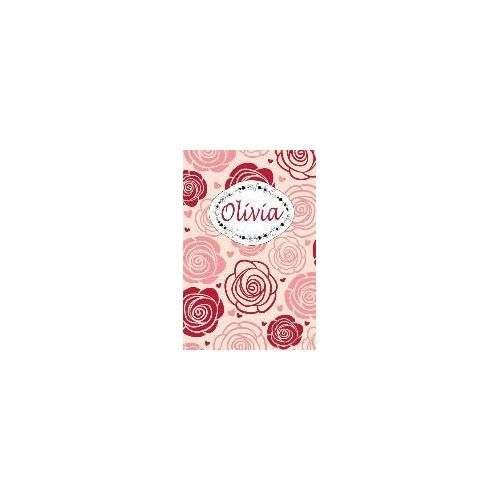
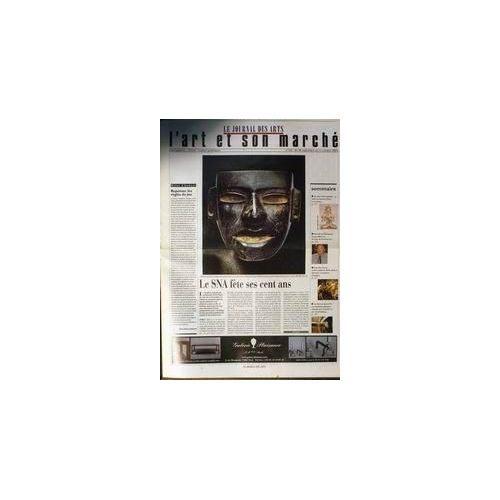

In [10]:
# On convertit les images locales en code HTML base64 pour l'afficher directement 
def obtenir_chemin_image(image_id):
    """Retourne le chemin de l'image à partir de son ID"""
    if str(image_id) in lookup:
        return str(lookup[str(image_id)])
    
    # Essayer une construction directe du chemin
    chemin_possible = IMG_DIR / f"image_{image_id}_product_{image_id}.jpg"
    return str(chemin_possible) if chemin_possible.exists() else None

def afficher_image(chemin, taille=256):
    """Convertit une image en HTML base64"""
    if not chemin or not Path(chemin).exists():
        return ""
    b64 = base64.b64encode(Path(chemin).read_bytes()).decode("ascii")
    return f'<img src="data:image/jpeg;base64,{b64}" width="{taille}" />'

# On ajoute une nouvelle colonne au df qui contient les chemins d'accès aux images correspondant à chaque imageid.

if 'imageid' in df.columns:
    df['image_path'] = df['imageid'].apply(obtenir_chemin_image)

# On affiche quelques images
colonnes_a_afficher = ["prdtypecode", "designation", "imageid", "image_path"]
colonnes_disponibles = [col for col in colonnes_a_afficher if col in df.columns]

if 'image_path' in df.columns:
    vue = df[colonnes_disponibles].head(2).copy()
    vue["image"] = vue["image_path"].apply(afficher_image)
    display(HTML(vue.drop(columns=["image_path"]).to_html(escape=False, index=True)))

<div style="background:#f0f8ff; padding:12px; border-radius:6px">Dans le but d'identifier les catégories correspondantes à chaque code produit, il serait intéressant d'afficher les images et les descriptions complètes ensemble. On va utiliser la fonction *display_df* qui permet d'afficher les images dans les cellules du dataframe à partir de leur chemin.

6.1 Observation des produits liés à un même code produit "prdtypecode" --> Nous allons procéder en filtrant une catégorie spécifique (ici cat = 10) et en affichant les premières entrées associées avec display_df, nous examinons les produits qui la composent.
L’observation se fait à la fois sur les images, mais également sur le contenu textuel des colonnes "designation" et "description".
Cette analyse nous permet de proposer un nom pertinent et cohérent pour la catégorie, nom qui sera ensuite contrasté et affiné à l’aide des nuages de mots générés afin de valider ou d'ajuster la dénomination retenue.

a) Exploration détaillée d'une catégorie

In [ ]:
# ============================================================================
# 6. OBSERVATION DES PRODUITS PAR CATÉGORIE
# ============================================================================

print("=== VÉRIFICATION ET CORRECTION DES IMAGES ===")

# 1. Diagnostic
print(f"Type de la colonne 'image': {type(df['image'].iloc[0])}")
print(f"Contenu du premier élément: {repr(df['image'].iloc[0])[:100]}...")

# 2. Si 'image' contient juste le texte "Image", recrear correctamente
if df['image'].iloc[0] == "Image" or not isinstance(df['image'].iloc[0], str) or 'base64' not in str(df['image'].iloc[0]):
    print("\n⚠️ La colonne 'image' ne contient pas de HTML base64. Recréation...")
    
    # Verificar que tenemos image_path
    if 'image_path' not in df.columns and 'imageid' in df.columns:
        print("Création de image_path...")
        df['image_path'] = df['imageid'].apply(obtenir_chemin_image)
    
    # Recrear la columna image con HTML base64
    print("Conversion des images en HTML base64...")
    df['image'] = df['image_path'].apply(lambda x: afficher_image(x, 150) if pd.notna(x) else "")
    
    print(f"✅ Colonne 'image' recréée. Exemple: {repr(df['image'].iloc[0])[:80]}...")

# 3. AHORA mostrar categoría 10 con DESIGNATION_CLEANED
print("\n" + "="*60)
print("EXPLORATION DE LA CATÉGORIE 10 (VERSIONS NETTOYÉES)")
print("="*60)

# Usar designation_cleaned en lugar de designation
categorie_10 = df[df['prdtypecode'] == 10]

# Seleccionar columnas limpias + imagen
colonnes_afficher = ['designation_cleaned', 'description_cleaned', 'image']
if all(col in categorie_10.columns for col in colonnes_afficher):
    produits_afficher = categorie_10[colonnes_afficher].head(3)
    
    # Convertir a HTML (escape=False para que el HTML de las imágenes se renderice)
    html_table = produits_afficher.to_html(escape=False, index=False)
    
    # Añadir estilo para mejorar visualización
    styled_html = f"""
    <style>
    table {{
        border-collapse: collapse;
        width: 100%;
    }}
    th, td {{
        border: 1px solid #ddd;
        padding: 8px;
        text-align: left;
    }}
    th {{
        background-color: #f2f2f2;
    }}
    img {{
        max-width: 150px;
        max-height: 150px;
        border-radius: 4px;
    }}
    </style>
    {html_table}
    """
    
    display(HTML(styled_html))
    
    print(f"\n📊 Catégorie 10: {len(categorie_10)} produits")
    print(f"   Images disponibles: {categorie_10['image'].str.contains('base64').sum()}")
    
else:
    print(f"Colonnes manquantes. Disponibles: {categorie_10.columns.tolist()}")

In [ ]:
# on affiche les premières lignes de la catégorie de code 10 avec l'image correspondante
display_df(df[df['prdtypecode']==10][['designation', 'description', 'image']], 3)

Ici, la catégorie 10 semble représenter des livres. En regardant chaque catégorie nous arrivons à les identifier. Nous allons maintenant donner un nom aux catégories identifiées dans la colonne *categories*.<br>
*L'identification des catégories s'est également appuyée sur des graphiques comme les nuages de mots qui seront vus plus loin dans ce notebook, cependant, pour rendre les graphiques qui suivent plus compréhensibles nous avont décidé de les renommer maintenant.*

b)Nommage des catégories à partir de leur contenu

In [ ]:
categories = {
    "Livres & Revues": {
        "Livres spécialisés": 10,
        "Littérature": 2705,
        "Presse & Magazines": 2280,
        "Séries & Encyclopédies": 2403,
    },

    "Jeux Vidéo": {
        "Rétro Gaming": 40,
        "Accessoires & Périphériques": 50,
        "Consoles": 60,
        "Jeux Vidéo Modernes": 2462,
        "Jeux PC en Téléchargement": 2905,
    },

    "Collection": {
        "Figurines": 1140,
        "Jeux de cartes": 1160,
        "Jeux de rôle & Figurines": 1180,
    },

    "Jouets, Jeux & Loisirs": {
        "Jouets & Figurines": 1280,
        "Jeux éducatifs": 1281,
        "Modélisme & Drones": 1300,
        "Loisirs & Plein air": 1302,
    },

    "Bébé": {
        "Vêtement Bébé & Loisirs": 1301,
        "Puériculture": 1320,
    },

    "Maison": {
        "Équipement Maison": 1560,
        "Textiles d'intérieur": 1920,
        "Décoration & Lumières": 2060,
    },

    "Jardin & Extérieur": {
        "Décoration & Équipement Jardin": 2582,
        "Piscine & Accessoires": 2583,
        "Bricolage & Outillage": 2585,
    },

    "Autres": {
        "Épicerie": 1940,
        "Animaux": 2220,
        "Bureau & Papeterie": 2522,
    }
}

groups_mapper = {}
categories_mapper = {}
for group, g_categories in categories.items():
    for cat, code in g_categories.items():
        groups_mapper[code] = group
        categories_mapper[code] = cat

df['category'] = df['prdtypecode'].replace(categories_mapper)
df['group'] = df['prdtypecode'].replace(groups_mapper)

<div style="background:#f0f8ff; padding:12px; border-radius:6px">

<h3 align="left">
6.1
Distribution des produits par catégorie
</div>

a) Affichage du pourcentage d'articles par catégories

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,9), gridspec_kw={"height_ratios": [3, 1]})

cat_counts = df['category'].value_counts()
sns.barplot(x=cat_counts.values, y=cat_counts.index, ax=ax1)
ax1.set_ylabel('catégorie')
ax1.set_xlabel('nombre de produits')
ax1.set_title('Distribution des articles par catégorie')

group_counts = df['group'].value_counts()
sns.barplot(x=group_counts.values, y=group_counts.index, ax=ax2)
ax2.set_ylabel('groupe')
ax2.set_xlabel('nombre de produits')
ax2.set_title('Distribution des articles par groupe de catégories')

plt.show()

print(
    f"La catégorie la plus représentée est {cat_counts.index[0]}.\nElle à ",
    round(cat_counts.iloc[0]/cat_counts.iloc[-1],1),
    f" fois plus d'articles que la catégorie {cat_counts.index[-1]} qui est la moins représentée.\n\n"
)

La catégorie la plus représentée est Piscine & Accessoires.
Elle à  13.1  fois plus d'articles que la catégorie Jeux de rôle & Figurines qui est la moins représentée.

<div style="background:#fff3cd; padding:12px; border-left:6px solid #ffdd57; border-radius:4px">

Nous remarquons que le jeu de données est déséquilibré. Il sera donc important de stratifier notre jeu lors des splits entraînement / validation pour conserver la distribution dans chacun de ces jeux et éviter d'avoir une classe ignorée car trop peu présente cela pourrait nuire à la performance des modèles sur certaines classes ou fausser l'évaluation car certaines classes y seraient sous-représentées ou sur-représentées. Nous avions vu qu'environ 30 000 descriptions était manquantes. Nous allons maintenant regarder si certaines catégories ont plus de descriptions manquantes que d'autres.</div>

b) Observation de la proportion des produits sans description par catégorie

In [ ]:
na_rates = df[df['description'].isna()][['group', 'category']].value_counts() / df[['group', 'category']].value_counts()
na_rates = na_rates.fillna(0).sort_values(ascending=False).reset_index()
sns.barplot(data=na_rates, x='count', y='category', hue='group')
plt.xlabel("proportion de produits sans description")
plt.ylabel("catégorie")
plt.title('Proportion de produits sans description par catégorie');

Ici on remarque que des catégories de produits comme les livres, les revues n'ont pas beaucoup de description, alors que les équipements de la maison en ont souvent. Cela semble cohérent, en général seul le titre d'un livre est nécessaire alors que pour les équipements il est souvent utile de décrire les dimensions par exemple.

c) Observation de la longueur moyenne des descriptions par catégorie

In [ ]:
df["description_cleaned_len"] = df["description_cleaned"].apply(len)
len_means = (df[~df['description'].isna()]
    .groupby(['group', 'category'])["description_cleaned_len"]
    .mean())

len_means = len_means.sort_values(ascending=False).reset_index()

sns.barplot(
    data=len_means,
    x='description_cleaned_len',
    y='category',
    hue='group'
)
plt.xlabel("nombre de caractères moyen des descriptions par catégorie")
plt.ylabel("catégorie")
plt.title('Longueur moyenne des descriptions par catégorie');


En plus d'avoir toujours des descriptions les jeux de PC en téléchargement semblent être très longue avec plus de 2000 caractères en moyenne.

<h3 align="left">
6.3 Traitement des mauvaises classifications
</div>

Le jeu de données est brut et il y a beaucoup de produits classés dans la mauvaise catégorie. Nous allons donc étiqueter les produits qui semblent mal classifiés. Pour cela nous allons utiliser la vectorisation TF-IDF, puis utiliser un modèle de régression logistique entraîné sur les variables issues de la vectorisation et à l'aide de la librairie CleanLearning detecter les produits "suspects". Les données pour lesquels le modèle va prédire une autre classe avec une probabilité élevée seront étiquetées comme suspectes.

a) Détection des incohérences dans la classification produit




In [ ]:
stop_words = set(stopwords.words('french'))   # on récupère un stopwords adapté au français

# le paramètre ngram_range=(1,2) permet de récupérer unigramme et bigramme
# (par default c'est uniquement les unigrammes, i.e. séquence de un seul mot)
vectorizer = TfidfVectorizer(max_features=2000, stop_words=list(stop_words), ngram_range=(1,2))

text = (
    df["designation_cleaned"].fillna("") + " " +
    df["description_cleaned"].fillna("")
).str.lower()
tfidf = vectorizer.fit_transform(text)
tfidf = pd.DataFrame(tfidf.toarray(), columns=vectorizer.get_feature_names_out(), index=df.index)
tfidf["category"] = df["category"].values

In [ ]:
!pip install cleanlab


In [ ]:
from cleanlab.classification import CleanLearning
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression

enc = LabelEncoder()                              # il faut encoder sinon ça provoque une erreur; pour k classes les labels doivent être 0,...,k-1
y = enc.fit_transform(tfidf["category"])
clf = LogisticRegression(solver='lbfgs', class_weight="balanced", max_iter=500)   # class_weight="balanced" permet d'équilibrer les classes ???
cleaner = CleanLearning(clf)
cleaner.fit(tfidf.drop("category", axis=1), y)
label_issues = cleaner.get_label_issues()

In [ ]:
print(
    f"Il y a {label_issues['is_label_issue'].sum()} produits prédits comme mal classifiés, cela représente",
    f"{round(label_issues['is_label_issue'].sum()/len(df)*100, 2)} % des données."
)

b) Analyse des produits étiquetés ou non comme problématiques

In [ ]:
df['is_label_issue'] = label_issues.set_index(df.index)['is_label_issue']

# exemple d'un produit mal prédit mais pas tagué. Ici la prédiction semble correcte.
# Même s'il est personnalisé il s'agit d'un article de papeterie et ce n'est pas un livre.

i = 0

print("produit non étiqueté comme problématique.")
print(f"Catégorie de produit : {enc.inverse_transform(label_issues.iloc[i:i+1]['given_label'])[0]}")
print(f"Catégorie de produit prédite : {enc.inverse_transform(label_issues.iloc[i:i+1]['predicted_label'])[0]}")

display_df(df.iloc[i:i+1][['designation', 'description', 'image']])

i = 49

print("produit étiqueté comme problématique.")
print(f"Catégorie de produit : {enc.inverse_transform(label_issues.iloc[i:i+1]['given_label'])[0]}")
print(f"Catégorie de produit prédite : {enc.inverse_transform(label_issues.iloc[i:i+1]['predicted_label'])[0]}")

display_df(df.iloc[i:i+1][['designation', 'description', 'image']])

i = 16

print("produit étiqueté comme problématique.")
print(f"Catégorie de produit : {enc.inverse_transform(label_issues.iloc[i:i+1]['given_label'])[0]}")
print(f"Catégorie de produit prédite : {enc.inverse_transform(label_issues.iloc[i:i+1]['predicted_label'])[0]}")

display_df(df.iloc[i:i+1][['designation', 'description', 'image']])

Certains articles sont mal tagués mais cela permet d'avoir une base. Regardons maintenant entre quelles catégories les erreurs semblent fréquentes.

c) Répartition des erreurs par catégories

In [ ]:
mask = label_issues["is_label_issue"]

ct = pd.crosstab(
    label_issues[mask]["given_label"],
    label_issues[mask]["predicted_label"],
    normalize="index",
)
ct.columns = enc.inverse_transform(ct.columns)
ct.index = enc.inverse_transform(ct.index)

# mask = np.eye(len(ct), dtype=bool)

plt.figure(figsize=(10, 7))
# sns.heatmap(ct, cmap="Reds", mask=mask, linewidths=.5)
sns.heatmap(ct, cmap="Reds", linewidths=0.5)
plt.ylabel("catégorie labélisée")
plt.xlabel("catégorie prédite")
plt.title("Confusions entre catégories")
plt.show()

On peut remarquer que les catégories Jeux éducatifs et Jouets, figurines semblent se confondre. Sûrement du à une proximité. A priori il y a beaucoup d'erreurs où des livres spécialisés sont labélisés comme des livres de littérature, un peu moins dans le cas inverse. Les erreurs semblent se produire dans des catégories proches.

Approche quantitative : analyse lexicale TF-IDF

Nous allons également faire un nuage de mots par catégories cela permettra de contrôler le nommage de catégories mais également de faire une première analyse sémantique. Pour générer les nuages de mots, nous allons d'abord définir une liste stop_words des mots à exclure de nos nuages de mots, puis faire une vectorisation TF-IDF pour génerer les nuages de mots. "Cela permettra de rendre les nuages de mots plus spécifique à chaque catégorie" (à vérifier si ça a un sens)

# VII - Caractérisation quantitative des catégories par analyse discriminante

<div style="background:#f0f8ff; padding:12px; border-radius:6px">

<h3 align="left">7.1 Exploration thématique par nuages de mots</span>
</div>


In [ ]:
def images_grid(images, nrows=5, ncols=10, cmap=None, titles=None, ordered_by_rows=True, axes_size=(1.5, 1.5)):
    fig, axes = plt.subplots(nrows, ncols, figsize=(axes_size[0]*ncols, axes_size[1]*nrows), squeeze=False)
    axes = axes.flatten()
    if ordered_by_rows:
        axes_order = range(nrows*ncols)
    else:
        axes_order = [i*ncols + j for j in range(ncols) for i in range(nrows)]
    for i in range(nrows*ncols):
        k = axes_order[i]
        if i < len(images):
            axes[k].imshow(images[i], cmap=cmap)
            if titles:
                axes[k].set_title(titles[i], fontsize=8)
        axes[k].set_xticks([])
        axes[k].set_yticks([])
    plt.show()

b) Vérification de la cohérence entre le vocabulaire et le nom de la catégorie

In [ ]:
vectorizer = TfidfVectorizer(max_features=2000, stop_words=list(stop_words), ngram_range=(1,2))

tfidf = vectorizer.fit_transform(df['text'])
tfidf = pd.DataFrame(tfidf.toarray(), columns=vectorizer.get_feature_names_out(), index=df.index)
tfidf["category"] = df["category"].values

tfidf["group"] = df["group"].values

freqs = {}
tfidfgr = {}

for gr in sorted(tfidf["group"].unique()):
    mask = tfidf["group"] == gr
    freqs = {}
    freqs[gr] = tfidf[mask].drop(['category', 'group'], axis=1).mean().sort_values(ascending=False)
    vectorizer = TfidfVectorizer(max_features=2000, stop_words=list(stop_words), ngram_range=(1,2))
    tfidfgr[gr] = vectorizer.fit_transform(text[mask])
    tfidfgr[gr] = pd.DataFrame(tfidfgr[gr].toarray(), columns=vectorizer.get_feature_names_out(), index=df[mask].index)
    tfidfgr[gr]["category"] = df[mask]["category"].values
    means_by_cat = tfidfgr[gr].groupby("category").mean()
    for cat in means_by_cat.index:
        freqs[gr+' - '+cat] = means_by_cat.loc[cat].sort_values(ascending=False)
    wc = [WordCloud(width=500, height=500, background_color="white").generate_from_frequencies(f) for f in freqs.values()]
    print('-'*30,'Catégories du groupe', gr, '-'*30)
    images_grid(wc, 1, len(wc), titles=list(freqs), axes_size=(4,4))

Les nuages de mots semblent être en accord avec les catégories et groupes précédemment choisis. Maintenant que nous avons identifié les catégories et avant d'aller plus loin dans l'analyse sémantique, nous allons regarder la distribution des articles à travers les catégories.

<div style="background:#e8f4ff; 
            padding: 10px 15px;
            border-radius: 6px;
            margin: 10px 0 10px 20px;
            border-left: 4px solid #4a90e2;
            box-shadow: 1px 1px 3px rgba(0,0,0,0.05);">

<div style="display: flex; align-items: center; gap: 8px;">
<div style="background:#4a90e2; 
            color: white;
            padding: 2px 8px;
            border-radius: 12px;
            font-size: 0.85em;
            font-weight: bold;
            min-width: 45px;">
6.3.2 
</div>

<h4 style="margin: 0;
           color: #2c3e50;
           font-size: 1.1em;
           font-weight: 600;">
Analyse ciblée de mots-clés stratégiques
</h4>

</div>

</div>





In [ ]:
import re

def plot_keywords_heatmap(df, keywords, text_col="text", by="prdtypecode"):
    category_codes = sorted(df[by].unique())
    result = pd.DataFrame(index=keywords, columns=category_codes, dtype=float)
    for kw in keywords:
        pattern = fr"\b{re.escape(kw)}\b"
        contains_kw = df[text_col].astype(str).str.contains(pattern, na=False)
        freq = contains_kw.groupby(df[by]).mean()
        result.loc[kw, freq.index] = freq.values
    col_labels = [categories.get(code, str(code)) for code in category_codes]
    result_for_plot = result.copy()
    result_for_plot.columns = col_labels
    plt.figure(figsize=(14, len(keywords) * 0.6 + 4))
    sns.heatmap(result_for_plot.astype(float), annot=True, fmt=".2f", cmap="Blues")
    plt.title("Distribution des mots-clés par catégorie (proportion)")
    plt.xlabel("Catégorie")
    plt.ylabel("Mots-clés")
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


keywords = [ #"temp", "vidéo", "!",
    "cm", "hauteur",
    "piscine", "drone", "bébé", "tout",
    # "led", "&",
    "couleur",
    "coussin", "décoration", "matelas", "jouets", "oreiller"
]
df['group_cat'] = df['group'] + ' - ' + df['category']
plot_keywords_heatmap(df, keywords, by='group_cat')
df.drop('group_cat', axis=1)

Les jouets semblent être détectés dans les catégories de jouets mais également dans la catégorie des produits pour animaux. matelas est repéré dans la bonne catégorie dédiée (équipement de la maison) mais également dans la catégorie bébé - puériculture pour les matelas bébé, cela semble cohérent.
On peut remarquer qu'il y a des termes qui caractérisent clairement une catégorie par exemple oreiller et coussin pour Textiles d'intérieur, ou piscine pour Piscine & accessoire car ils sont très rarement présents dans les autres catégories.
Des termes comme "tout" semblent également être plus présents dans certaines catégories mais de manière moins marquée.

b) Calcul du taux d'apparition du mot "tout" par catégorie

In [ ]:
from matplotlib.ticker import PercentFormatter
import re

text_col = 'text'
keyword = "tout"
pattern = fr"\b{re.escape(keyword)}\b"
contains_word = df[text_col].str.contains(pattern, na=False)
len_text = df[text_col].apply(len)
agg = df.assign(contains_word=contains_word, len_text=len_text).groupby("category").agg(
    contains_ratio=("contains_word", "mean"),
    mean_len_text=("len_text", "mean"),
).reset_index()
agg
fig, ax1 = plt.subplots(figsize=(12, 5))
plt.xticks(rotation=45, ha="right")
sns.barplot(data=agg, x="category", y="contains_ratio", ax=ax1)
ax1.set_ylabel("Proportion contenant le mot")
ax1.yaxis.set_major_formatter(PercentFormatter(1.0))
ax2 = ax1.twinx()
ax2.plot(ax1.get_xticks(), agg["mean_len_text"], marker="o", linestyle="--", color='orange')
ax2.set_ylabel("Longueur de texte moyen")
ax1.set_xlabel("Catégorie")
plt.title(f"Fréquence du mot '{keyword}' par catégorie\n"
          f"(barres = mot, ligne = Longueur de texte moyen)")

fig.tight_layout()
plt.show()

Le taux d'apparition du mot "tout" par catégorie semble être corrélé à la longueur des descriptions et donc ne pas forcément apporter d'information supplémentaire (à part la forte proportion dans textiles et vêtements bébé & loisirs). On pourrait donc l'ajouter à notre variable stop_words. Nous pouvons effectuer le test de corrélation de Pearson entre la longueur moyenne des textes et le taux d'apparition du mot "tout" par catégorie.

 <div style="background:#f0f8ff; padding:12px; border-radius:6px">

<h3 align="left">7.2 Relation entre la longueur des textes et les mots génériques</span>
</div>


In [ ]:
import scipy.stats as stats

pearson_coeff, p_value = stats.pearsonr(agg['contains_ratio'], agg['mean_len_text'])

print(f"P value : {p_value:.4f}")
print(f"coefficient de corrélation : {pearson_coeff:.2f}")

Ici le score est plutôt élevé, ce qui montre qu'il y a une corrélation assez forte entre la longueur moyenne des textes et le taux d'apparition du mot "tout" par catégorie.<br>
On peut également remarquer que certains commentaires sont écrits en langues étrangères. Nous allons les taguer à l'aide de la librairie langdetect.

### 6.4. Détection de la langue des descriptions

In [ ]:
!pip install langdetect

In [ ]:
from langdetect import detect, DetectorFactory

# Fixe la graine pour des résultats reproductibles
DetectorFactory.seed = 0

# Fonction de détection
def detect_lang(text):
    try:
        return detect(text)
    except:
        return "unknown"

df["detected_lang"] = df["text"].apply(detect_lang)

In [ ]:
fr_rate = df[df["detected_lang"] == 'fr'][['group', 'category']].value_counts() / df[df["detected_lang"] != 'unknown'][['group', 'category']].value_counts()
fr_rate = fr_rate.sort_values(ascending=False).reset_index()
plt.figure(figsize=(12,7))
sns.barplot(data=fr_rate, x='count', y='category', hue='group')
plt.title("Taux de description ou désignation écrite en français")
plt.ylabel('catégorie')
plt.xlabel('proportion de texte en français parmi les textes dont la langue a été identifiée');

In [ ]:
mask = (df["detected_lang"] != 'fr') & (df["detected_lang"] != 'unknown')
ct = pd.crosstab(df[mask]["detected_lang"], df[mask]["group"])
ct = ct.loc[ct.sum(axis=1).sort_values(ascending=False).index]
# pour faire une catégorie "autre" et simplifier le graphique
th = 300
other = ct[ct.sum(axis=1) <= th]
ct = ct.drop(other.index)
ct.loc['autre',:] = other.sum()

ct.plot(kind='bar', stacked=True);
plt.title(f"nombre de texte par langue parmi les {mask.sum()} textes détectés en langues étrangères")
plt.xlabel('langue detectée');

# VIII - Features

In [ ]:
print(df.info())

Ajout d'une colonne "text_clean" contenant le titre et la description produit.

In [ ]:
df["text_clean"] = (
    df["designation_cleaned"].fillna("") + " " +
    df["description_cleaned"].fillna("")
)

df[["designation_cleaned", "description_cleaned", "text_clean"]].head()


<h3 align="center">
7.1. Analyse du nombre de chiffres présent par catégories
</h3>
</div>




Objectif: compter le nombre de chiffres présent en moyenne dans chaque catégorie afin de savoir si les produits sont décrits plutôt avec des phrases ou avec des chiffres (tailles, dimensions, références etc.) et de mesurer el niveau de technicité d'une catégorie.



a) Observation de la moyenne des chiffres par catégorie

In [ ]:
def count_digits(text):
    """
    Compte le nombre de chiffres (0-9) dans une chaîne de caractères.
    """

    compteur = 0
    for caractere in text:
        if caractere.isdigit():
            compteur = compteur + 1
    return compteur

df["nb_digits_text"] = df["text_clean"].apply(count_digits)

df[["text_clean", "nb_digits_text"]].head(10)


Savoir combien il y a de chiffres dans les textes produits permettra de savoir

*   si la feature "nb_digits_text" est pertinente à prendre en compte,
*   quelles sont les catégories qui ont le plus de chiffres.



b) Identification des catégories possedant le plus de chiffres

In [ ]:
target_col = "category"

liste_categories = df[target_col].unique()

resultats = []

for cat in sorted(liste_categories):
    sous_df = df[df[target_col] == cat]
    moyenne = sous_df["nb_digits_text"].mean()
    mediane = sous_df["nb_digits_text"].median()
    minimum = sous_df["nb_digits_text"].min()
    maximum = sous_df["nb_digits_text"].max()

    resultats.append({
        "category": cat,
        "mean_nb_digits": moyenne,
        "median_nb_digits": mediane,
        "min_nb_digits": minimum,
        "max_nb_digits": maximum
    })

stats_digits = pd.DataFrame(resultats)

stats_digits = stats_digits.sort_values("mean_nb_digits", ascending=False)

stats_digits.head(15)


Résultat: nous constatons que les moyennes sont très differentes en fonction des catégories (46.5 pour les jeux PC en téléchargement contre 15 pour la catégorie Bureau&Papeterie) donc "nb_digits_text" est bien une feature discriminantes.

In [ ]:
plt.figure(figsize=(12, 4))

plt.bar(
    stats_digits["category"].astype(str),
    stats_digits["mean_nb_digits"]
)

plt.xlabel("Catégorie")
plt.ylabel("Moyenne de chiffres\n(titre + description)")
plt.title("Moyenne de chiffres par catégorie")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


Les catégories contenant le plus de chiffres (Jeux PC en téléchargement, Modélisme&Drone) contiennent généralement des références techniques, produit, tailles de fichiers, version ou encore des dimensions.

Les catégories contenant le moins de chiffres ont des description axées litterature (Livres spécialisés, Littérature).



### 7.2 Détection d'unités par catégorie




Objectif: identifier, pour chaque description produit, la présence d’unités de mesure (cm, mm, kg, L, ml, W, V, Go, etc.), puis analyser leur distribution par catégorie.

a) Dictionnaire des unités de mesure présentes dans les textes

In [ ]:

unit_patterns = {
    # Dimensions
    "cm":   r"\b\d+\s*(cm|centimetre?s?|centimètre?s?)\b",
    "mm":   r"\b\d+\s*(mm|millimetre?s?|millimètre?s?)\b",
    "m":    r"\b\d+\s*(m|metre?s?|mètre?s?)\b",

    # Poids
    "kg":   r"\b\d+\s*(kg|kilo|kilogramme?s?)\b",
    "g":    r"\b\d+\s*(g|gramme?s?)\b",

    # Volume
    "ml":   r"\b\d+\s*(ml|millilitres?|millilitre?)\b",
    "l":    r"\b\d+\s*(l|litres?|litre?)\b",
    "cl":   r"\b\d+\s*cl\b",  # ex : 50cl

    # Dimensions éventuellement suivies d'une unité
    "x_dim": r"\b\d+\s*(x|×)\s*\d+(\s*(cm|mm|m))?\b",

    # Âge
    "age_ans":  r"\b\d+\s*ans\b",
    "age_mois": r"\b\d+\s*mois\b",

    # Pouces (écrans, certains produits tech)
    "inch": r'\b\d+\s*(\"|pouces?|po)\b',
}

compiled_patterns = []
for pattern in unit_patterns.values():
    regex_obj = re.compile(pattern, flags=re.IGNORECASE)
    compiled_patterns.append(regex_obj)


In [ ]:
def detect_any_unit(text, list_of_regex):
    """
    Retourne 1 si le texte contient au moins une unité (parmi la liste de regex),
    sinon 0.
    """
    text = str(text)

    for regex_pattern in list_of_regex:
        if regex_pattern.search(text):
            return 1
    return 0



In [ ]:
df["has_any_unit"] = df["text_clean"].apply(
    lambda txt: detect_any_unit(txt, compiled_patterns)
)

df[["text_clean", "has_any_unit"]].head(10)


b) Fréquence des unités par catégorie produit

Ici, on cherche à savoir dans chaque catégorie, quel pourcentage de produits contient au moins une unité.

In [ ]:
target_col = "category"

liste_categories = sorted(df[target_col].unique())

resultats = []

for cat in liste_categories:
    sous_df = df[df[target_col] == cat]

    nb_produits = len(sous_df)
    if nb_produits == 0:
        continue

    taux_unites = sous_df["has_any_unit"].mean()
    pourcentage = taux_unites * 100

    resultats.append({
        "categorie": cat,
        "nb_products": nb_produits,
        "pct_products_with_unit": pourcentage
    })

stats_units_any = pd.DataFrame(resultats)

# Affichage des catégories par pourcentage décroissant
stats_units_any = stats_units_any.sort_values(
    "pct_products_with_unit",
    ascending=False
)

stats_units_any.head(20)


Nous constatons que la catégorie "Textiles d'intérieur" contient quasi systématiquement des mesures(90%) contrairement à d'autres comme Jeux de rôle& Figurines(15%). La feature "has_any_unit" est donc très caractéristique.

c) Affichage de toutes les catégories en fonction du nombre d'unités quelles possèdent

In [ ]:
plt.figure(figsize=(10, 6))


plot_df = stats_units_any.sort_values("pct_products_with_unit", ascending=True)

plt.barh(
    plot_df["categorie"].astype(str),
    plot_df["pct_products_with_unit"]
)

plt.xlabel("Pourcentage de produits avec au moins une unité (%)")
plt.ylabel("Catégorie")
plt.title("Pourcentage de produits contenant des unités par catégorie")
plt.tight_layout()
plt.show()


Résultat: nous constatons que les catégories se distinguent bien:

*   Vêtement Bébé & Loisirs (73 %), cohérent avec les âges (ans, mois) et parfois dimensions.
*   Bricolage & Outillage (72 %),  mm, cm, W, V, etc., très cohérent également.


d) Combinaison du nombre de chiffres et d'unités par catégorie





In [ ]:
target_col = "category"

liste_categories = sorted(df[target_col].unique())

resultats_cat = []

for cat in liste_categories:
    sous_df = df[df[target_col] == cat]

    nb_produits = len(sous_df)
    if nb_produits == 0:
        continue

    mean_nb_digits = sous_df["nb_digits_text"].mean()


    taux_unites = sous_df["has_any_unit"].mean()
    pct_with_unit = taux_unites * 100

    resultats_cat.append({
        "category": cat,
        "nb_products": nb_produits,
        "mean_nb_digits": mean_nb_digits,
        "pct_with_unit": pct_with_unit
    })

stats_cat = pd.DataFrame(resultats_cat)

stats_cat.head()


In [ ]:
plt.figure(figsize=(11, 11))

plt.scatter(
    stats_cat["mean_nb_digits"],
    stats_cat["pct_with_unit"]
)

plt.xlabel("Nombre moyen de chiffres (titre + description)")
plt.ylabel("Pourcentage de produits avec unités (%)")
plt.title("Catégories : technicité (chiffres) vs usage d'unités")

seuil_pct = 70
seuil_digits = stats_cat["mean_nb_digits"].quantile(0.9)

for _, row in stats_cat.iterrows():
    x = row["mean_nb_digits"]
    y = row["pct_with_unit"]
    nom_cat = str(row["category"])

    if (y > seuil_pct) or (x > seuil_digits):
        plt.text(x + 0.1, y + 1, nom_cat, fontsize=8)

plt.tight_layout()
plt.show()



Plus une catégorie est technique plus elle est située vers le haut à droite. Les catégories les moins techniques sont situés vers le bas à gauche.

Les jeux PC en téléchargement ont beaucoup de chiffres et peu d'unités, cela peut correspondre à des versions, numéros de produits.

Les produits techniques comportant des souvent dimensions (piscines&accessoires, bricolage&outillage) ont des descriptions qui conrrespondent à des spécifications produits. Leur localisation correspondent bien à leur typologie.

### 7.3 Analyse de la relation entre taille/pointure et âge par catégorie

In [ ]:
stats_patterns = (
    df.groupby("category")
      .agg(
          nb_products=("category", "size"),
          pct_with_clothing_size=("has_clothing_size", "mean"),
          pct_with_age_range=("has_age_range", "mean"),
      )
      .reset_index()
)

stats_patterns["pct_with_clothing_size"] *= 100
stats_patterns["pct_with_age_range"] *= 100

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))

plt.scatter(
    stats_patterns["pct_with_clothing_size"],
    stats_patterns["pct_with_age_range"]
)

plt.xlabel("% de produits avec tailles / pointures")
plt.ylabel("% de produits avec mention d'âge (mois / ans)")
plt.title("Catégories : tailles vêtements vs mentions d'âge")

for _, row in stats_patterns.iterrows():
    x = row["pct_with_clothing_size"]
    y = row["pct_with_age_range"]
    nom_cat = str(row["category"])   # on utilise la colonne 'category'

    plt.text(x + 0.5, y + 0.5, nom_cat, fontsize=8)

plt.tight_layout()
plt.show()


Les catégories contenant des produits généralement classés par âge se distinguent: vêtement bébé & loisirs, jeux éducatifs, puériculture contrairement aux catégories "animaux et  textiles d'intérieur.


<h3 align="center">
7.4 Présence de numéro dans la description produit
</h3>


Objectif: détecter les mentions de type "n°4838" dans les descriptions produit afin d'identifier les catégories où la notion de numéro est fréquente.

In [ ]:
df["contains_numerotation"] = df["text_clean"].str.contains(r"n° ?([0-9])+")
num_counts = (df[df["contains_numerotation"]]["category"].value_counts() / df["category"].value_counts()).fillna(0).sort_values(ascending=False)
sns.barplot(num_counts, orient='h')
plt.xlabel('proportion');

Nous constatons que certains produits possèdent des numéros de parution, cela concerne plus de 80% de la catégorie "Presse&Magazine".

Résultat: la feature contains_numerotation est très spécifique des produits de type presse et est donc discriminant donc pertinent à prendre en compte.

En conclusion, les features dérivées des chiffres, des unités et des
mentions d’âge / taille / pointure apportent une distinction forte, elles permettent de mieux séparer les familles de produits et de comprendre ce que le modèle pourra exploiter au-delà de TF-IDF.

In [ ]:
y.value_counts()[:5]

In [ ]:
# exemple; on affiche les 5 premières entrées de la catégorie 2583

cat = 1301
display_df(df[y == cat], 5)

### 7.5 Tester l'impact de variables indicatrices sur la présence ou non de certains mots

Avec cette feature, nous  cherchons à mesurer l’impact de variables indicatrices simples basées sur la présence ou l’absence de certains mots clés dans les descriptions produits. L’objectif est de vérifier si ces marqueurs textuels apportent une information complémentaire. Nous examinerons ainsi dans quelle mesure ces features peuvent aider à mieux différencier certaines catégories de produits.

In [ ]:
df[df.detected_lang == "fr"]
df= df[df.detected_lang == "fr"]

a) Création des variables de la feature

In [ ]:
import pandas as pd
import numpy as np

# 1. Definir les mots clés par catégorie

keyword_dict = {
    "Animaux": [ "chien", "chat", "animal", "compagnie", "collier"],
    "Bureau & Papeterie": ["verso", "cahier", "encre", "papier", "recto", "a5"],
    "Épicerie": ["epices", "arôme", "chocolat", "sucre", "sachet", "capsule"],
    "Puériculture": ["langer", "bavoir", "assiette", "siege", "tétine", "poussette"],
    "Vêtement Bébé & Loisirs": ["bébé", "chaussettes", "paire", "longueur", "filles","garçons"],
    "Figurines": ["figurine", "gundam", "statuette", "officiel", "marvel", "funko"],
    "Jeux de cartes":["mtg", "oh", "rare", "vf", "carte", "magic"],
    "Jeux de rôle & Figurines": ["halloween", "figurine", "warhammer", "prince", "masque"],
    "Bricolage & Outillage": ["arrosage", "tondeuse", "aspirateur", "appareils", "outil", "coupe", "bâche"],
    "Décoration & Équipement Jardin": ["bois", "jardin", "résistant", "tente", "parasol", "aluminium"],
    "Piscine & Accessoires": ["piscine", "filtration", "pompe", "dimensions","eau", "ronde"],
    "Accessoires & Périphériques":["nintendo", "manette", "protection", "ps4", "silicone", "câble"],
    "Consoles": ["console", "oui", "jeu", "écran", "portable", "marque", "jeux"],
    "Jeux PC en Téléchargement":["windows", "jeu", "directx", "plus", "téléchargement", "disque", "édition"],
    "Jeux Vidéo Modernes": ["duty","jeux", "manettes", "ps3", "xbox", "kinect"],
    "Rétro Gaming": ["japonais", "import", "langue", "titres", "sous", "français"],
    "Jeux éducatifs": ["joue", "cartes", "enfants", "éducatif", "bois", "jouer"],
    "Jouets & Figurines": ["doudou", "enfants", "cadeau", "peluche", "jouet", "puzzle"],
    "Loisirs & Plein air": ["camping", "pêche", "stress", "stream", "bracelet", "trampoline"],
    "Modélisme & Drones": ["drone", "générique", "dji", "avion", "batterie", "cámera", "one"],
    "Littérature": ["monde", "ouvrage", "siècle", "roman", "livre", "histoire", "tome"],
    "Livres spécialisés": ["guide", "édition", "histoire", "art", "collection"],
    "Presse & Magazines": ["journal", "france", "illustre", "magazine", "presse", "revue"],
    "Séries & Encyclopédies":[ "lot", "livres", "tomes", "volumes", "tome", "revues"],
    "Décoration & Lumières": ["led", "noël", "lumière", "lampe", "décoration", "couleur"],
    "Textiles d'intérieur": ["oreiller", "taie", "coussin", "couverture", "canapé", "cotton"],
     "Équipement Maison":["matelas", "assise", "bois", "table", "hauteur", "mousse"]

}

# Construire un texte global
df["text"] = (df["designation_cleaned"].fillna("") + " " +df["description_cleaned"].fillna("")).str.lower()

# Génération des colonnes de comptage

data = {}

for cat, mots in keyword_dict.items():
    pattern = '|'.join(mots)  # expression régulière
    data[cat + "_keywords"] = df["text"].str.count(pattern)

# Convertir en DataFrame final
new_X = pd.DataFrame(data)
new_X

In [ ]:
# keywords / catégorie
total_keywords_per_category = new_X.sum().sort_values(ascending = False)
total_keywords_per_category



b) Analyse de la distribution par catégorie

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
y = df['category']
for keyword in [  "assise"]:
    count_kw = df["text"].str.lower().str.count(keyword)
    cat_counts = y.value_counts()
    freq = {}
    for cat, count in cat_counts.items():
        freq[cat] = count_kw[y==cat].sum() / count
    sns.barplot(y=freq.keys(), x=freq.values(), orient='h')
    plt.title(keyword)
    plt.show()

 #   "Textiles d'intérieur": ["oreiller", "taie", "coussin", "couverture", "canapé", "cotton"] "Équipement Maison":







In [ ]:


# Créer un DataFrame booléen : True si au moins 1 mot-clé
has_keyword = new_X >= 1

# Calculer le pourcentage de produits avec ≥1 mot-clé par catégorie
percentage_per_category = has_keyword.sum() / len(new_X) * 100

# Trier de manière décroissante
percentage_per_category = percentage_per_category.sort_values(ascending=False)

# Graphique en barres
plt.figure(figsize=(12, 6))
plt.bar(percentage_per_category.index, percentage_per_category.values, color='skyblue')
plt.xticks(rotation=90)
plt.ylabel("Pourcentage de produits (%)")
plt.title("Pourcentage de produits avec au moins 1 mot-clé par catégorie")
plt.ylim(0, 100)
plt.tight_layout()
plt.show()



In [ ]:

# Catégorie dominante de mots-clés par produit
categorie_motcle_dominante = new_X.idxmax(axis=1)

# Tableau croisé : lignes = catégorie officielle, colonnes = catégorie dominante de mots-clés
distribution = pd.crosstab(df['category'], categorie_motcle_dominante)

# --- Palette de 27 couleurs bien distinctes ---
from itertools import chain
import matplotlib.pyplot as plt

# Combinaison de palettes très contrastées
palette1 = plt.cm.tab20.colors          # 20 couleurs
palette2 = plt.cm.tab10.colors          # 10 couleurs
palette = list(chain(palette1, palette2))[:27]  # 27 couleurs bien différentes

# --- Graphique en barres empilées ---
fig, ax = plt.subplots(figsize=(14, 7))

bottom = np.zeros(len(distribution))
categories_officielles = distribution.index

for i, kw_cat in enumerate(distribution.columns):
    ax.bar(
        categories_officielles,
        distribution[kw_cat],
        bottom=bottom,
        label=kw_cat,
        color=palette[i]  # couleurs distinctes
    )
    bottom += distribution[kw_cat].values

ax.set_ylabel("Nombre de produits")
ax.set_title("Distribution des catégories de mots-clés dominantes par catégorie officielle")
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


# IX. Dataset final

a) Intégration des nouvelles features dans le DataFrame final

In [ ]:
# Colonnes de base pour la modélisation
base_cols = [
    "prdtypecode",
    "designation_cleaned",
    "description_cleaned",
    "text_clean",
    "dup_count",
    "is_duplicated_group",
]

# Features crées
created_features = [
    "nb_digits_text",
    "has_any_unit",
    "contains_numerotation",
]

# Construction de la liste finale des colonnes
cols_for_modeling = base_cols + created_features + list(new_X.columns)

# Jointure et sélection des colonnes
df_final = df.join(new_X)[cols_for_modeling].copy()

df_final.head()


 b) Export du dataset enrichi pour les notebooks de modélisation

Maintenant que les features sont consolidées, il est essentiel d’exporter le dataset afin qu’il puisse être utilisé dans les notebooks dédiés à la modélisation.

In [ ]:
df_final.to_csv("rakuten_features_v1.csv", index=False, encoding="utf-8")


# X. Conclusion


Ce notebook a permis de préparer et de structurer le texte du dataset Rakuten. Nous disposons désormais d’un jeu de données propre, enrichi et prêt pour la modélisation.

Les éléments clés mis en place dans ce notebook sont :

- le nettoyage du texte : harmonisation des champs, réduction du bruit, préservation des informations utiles,

- analyse lexicale : mise en évidence de motifs discriminants (unités, nombres, termes techniques),

-gestion des doublons: réduction des biais liés aux répétitions et incohérences,

-création de features: signaux complémentaires à TF-IDF pour mieux capturer les spécificités des catégories.






Difficultés et biais identifiés:

- forte variabilité et bruit dans les textes

- classes déséquilibrées

- description absente pour une part importante des produits

- doublons fréquents

- hétérogénéité linguistique (syntaxe, graphies, niveaux de détails)

- erreurs ou imprécisions de labellisation

    Ces constats constituent des points d’attention pour l'étape de modélisation.
Nous allons maintenant poursuivre avec l’analyse des images dans un second notebook.
